# Model

Fire detection using VGG16 refers to a method of identifying and detecting fires in images or video frames using the VGG16 convolutional neural network (CNN) architecture. VGG16 is a popular CNN model that has been widely used for various computer vision tasks, including image classification.

In [1]:
import os
import cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Files
path=r'C:\Users\AL-FAJR\Desktop\New folder (2)\fire_dataset'
pd.DataFrame(os.listdir(path),columns=['Files'])

Files
0      fire_images
1  non_fire_images

In [4]:
train_data_dir =path
batch_size = 32
target_size = (224, 224)
validation_split = 0.2
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=44,
    image_size=target_size,
    batch_size=batch_size,
)

Found 1460 files belonging to 2 classes.
Using 1168 files for training.
Found 1460 files belonging to 2 classes.
Using 292 files for validation.


In [5]:
class_names = train.class_names
class_names

['fire_images', 'non_fire_images']

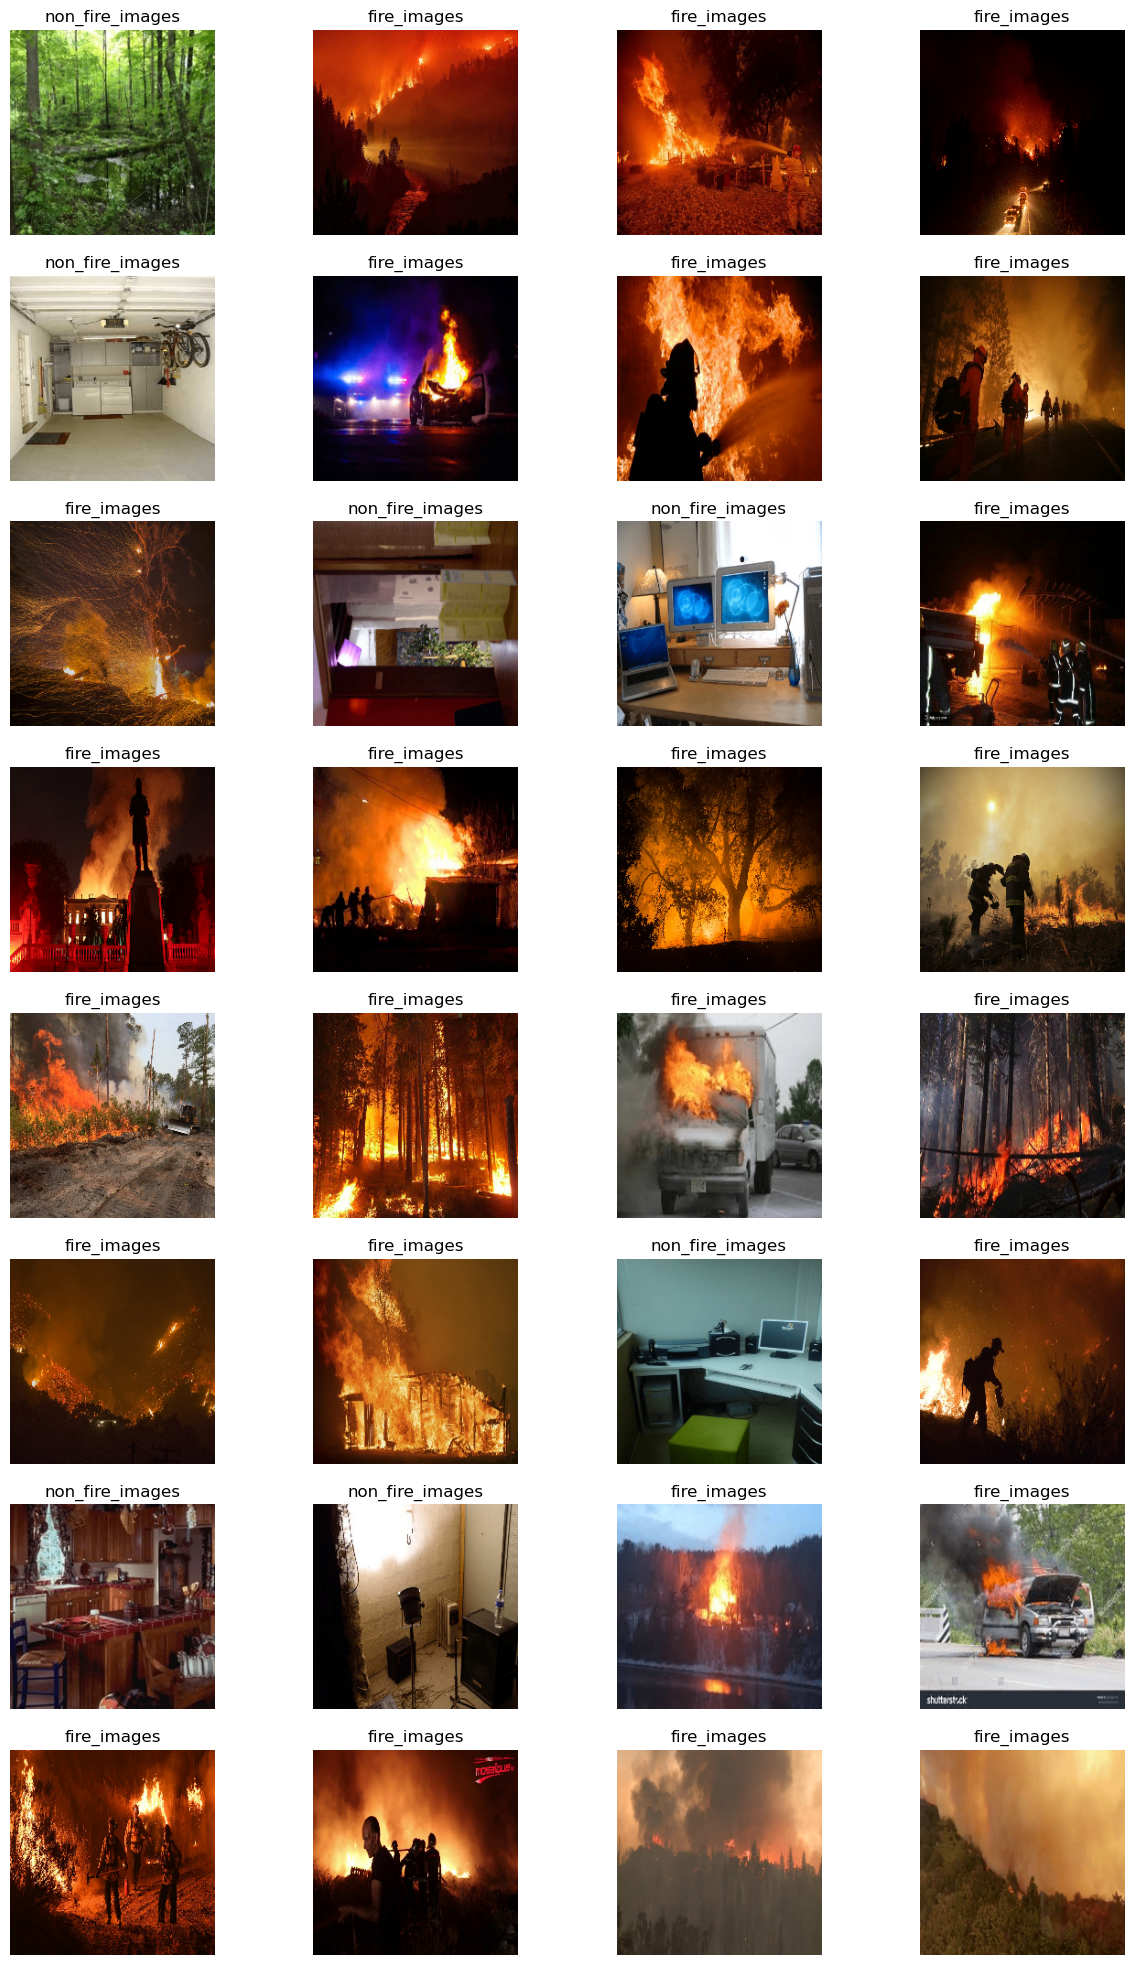

In [6]:
plt.figure(figsize=(15, 25))
for images, labels in train.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
model=keras.models.Sequential()
model.add(base_model)
model.add(keras.layers.Flatten()) 
model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(1,activation=tf.nn.sigmoid))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [8]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [9]:
checkpoint_cb =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=3, restore_best_weights=True)
model.compile(optimizer ='adam',loss='binary_crossentropy', metrics=['accuracy'])
hist=model.fit_generator(train,epochs=20,validation_data=validation,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/20
37/37 [==============================] - 315s 9s/step - loss: 1.7334 - accuracy: 0.8930 - val_loss: 0.4669 - val_accuracy: 0.9486
Epoch 2/20
37/37 [==============================] - 327s 9s/step - loss: 0.3091 - accuracy: 0.9709 - val_loss: 0.2499 - val_accuracy: 0.9760
Epoch 3/20
37/37 [==============================] - 343s 9s/step - loss: 0.1034 - accuracy: 0.9906 - val_loss: 0.0833 - val_accuracy: 0.9897
Epoch 4/20
37/37 [==============================] - 367s 10s/step - loss: 0.0184 - accuracy: 0.9949 - val_loss: 0.0756 - val_accuracy: 0.9897
Epoch 5/20
37/37 [==============================] - 371s 10s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0666 - val_accuracy: 0.9863
Epoch 6/20
37/37 [==============================] - 360s 10s/step - loss: 0.0165 - accuracy: 0.9966 - val_loss: 0.1010 - val_accuracy: 0.9863
Epoch 7/20
37/37 [==============================] - 333s 9s/step - loss: 0.0310 - accuracy: 0.9974 - val_loss: 0.1104 - val_accuracy: 0.9863
Epoch 8/20

In [12]:
# Accessing training and validation accuracy
training_accuracy = hist.history['accuracy']
validation_accuracy = hist.history['val_accuracy']



In [13]:
training_accuracy[-1]

0.9991438388824463

In [14]:
score, acc = model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

10/10 [==============================] - 66s 7s/step - loss: 0.0666 - accuracy: 0.9863
Test Loss = 0.06656518578529358
Test Accuracy = 0.9863013625144958


In [15]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0  1.733433  0.892979  0.466858      0.948630
1  0.309109  0.970890  0.249907      0.976027
2  0.103425  0.990582  0.083322      0.989726
3  0.018399  0.994863  0.075606      0.989726
4  0.001189  1.000000  0.066565      0.986301
5  0.016506  0.996575  0.101050      0.986301
6  0.030997  0.997432  0.110402      0.986301
7  0.006136  0.999144  0.119393      0.986301

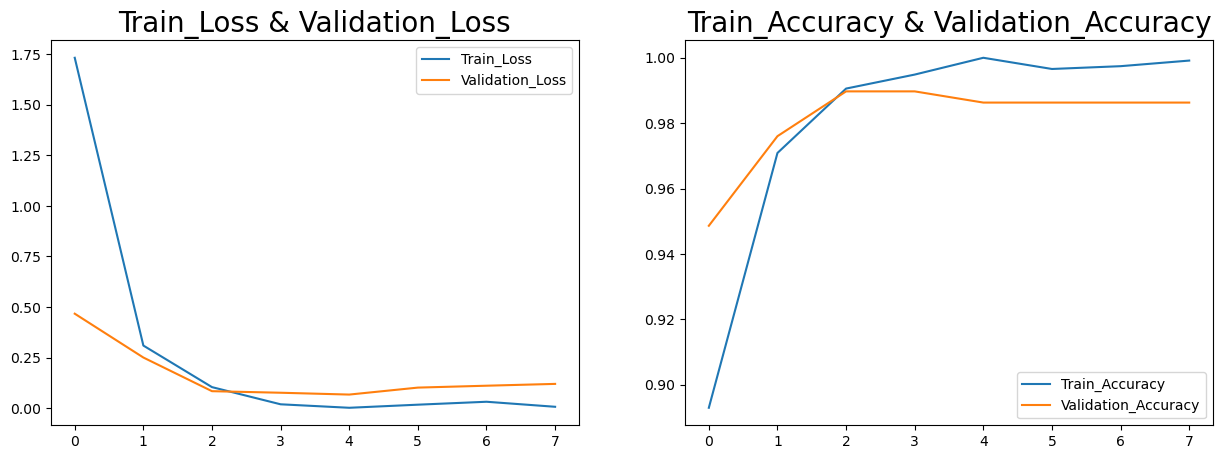

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [18]:
X_val,y_val=[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=model.predict(np.array(X_val))
y_pred=np.where(predictions>=.5,1,0)
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

10/10 [==============================] - 89s 9s/step


Actual  Prediction
0         0           0
1         0           0
2         0           0
3         1           1
4         1           1
..      ...         ...
287       0           0
288       1           1
289       0           0
290       1           1
291       0           0

[292 rows x 2 columns]

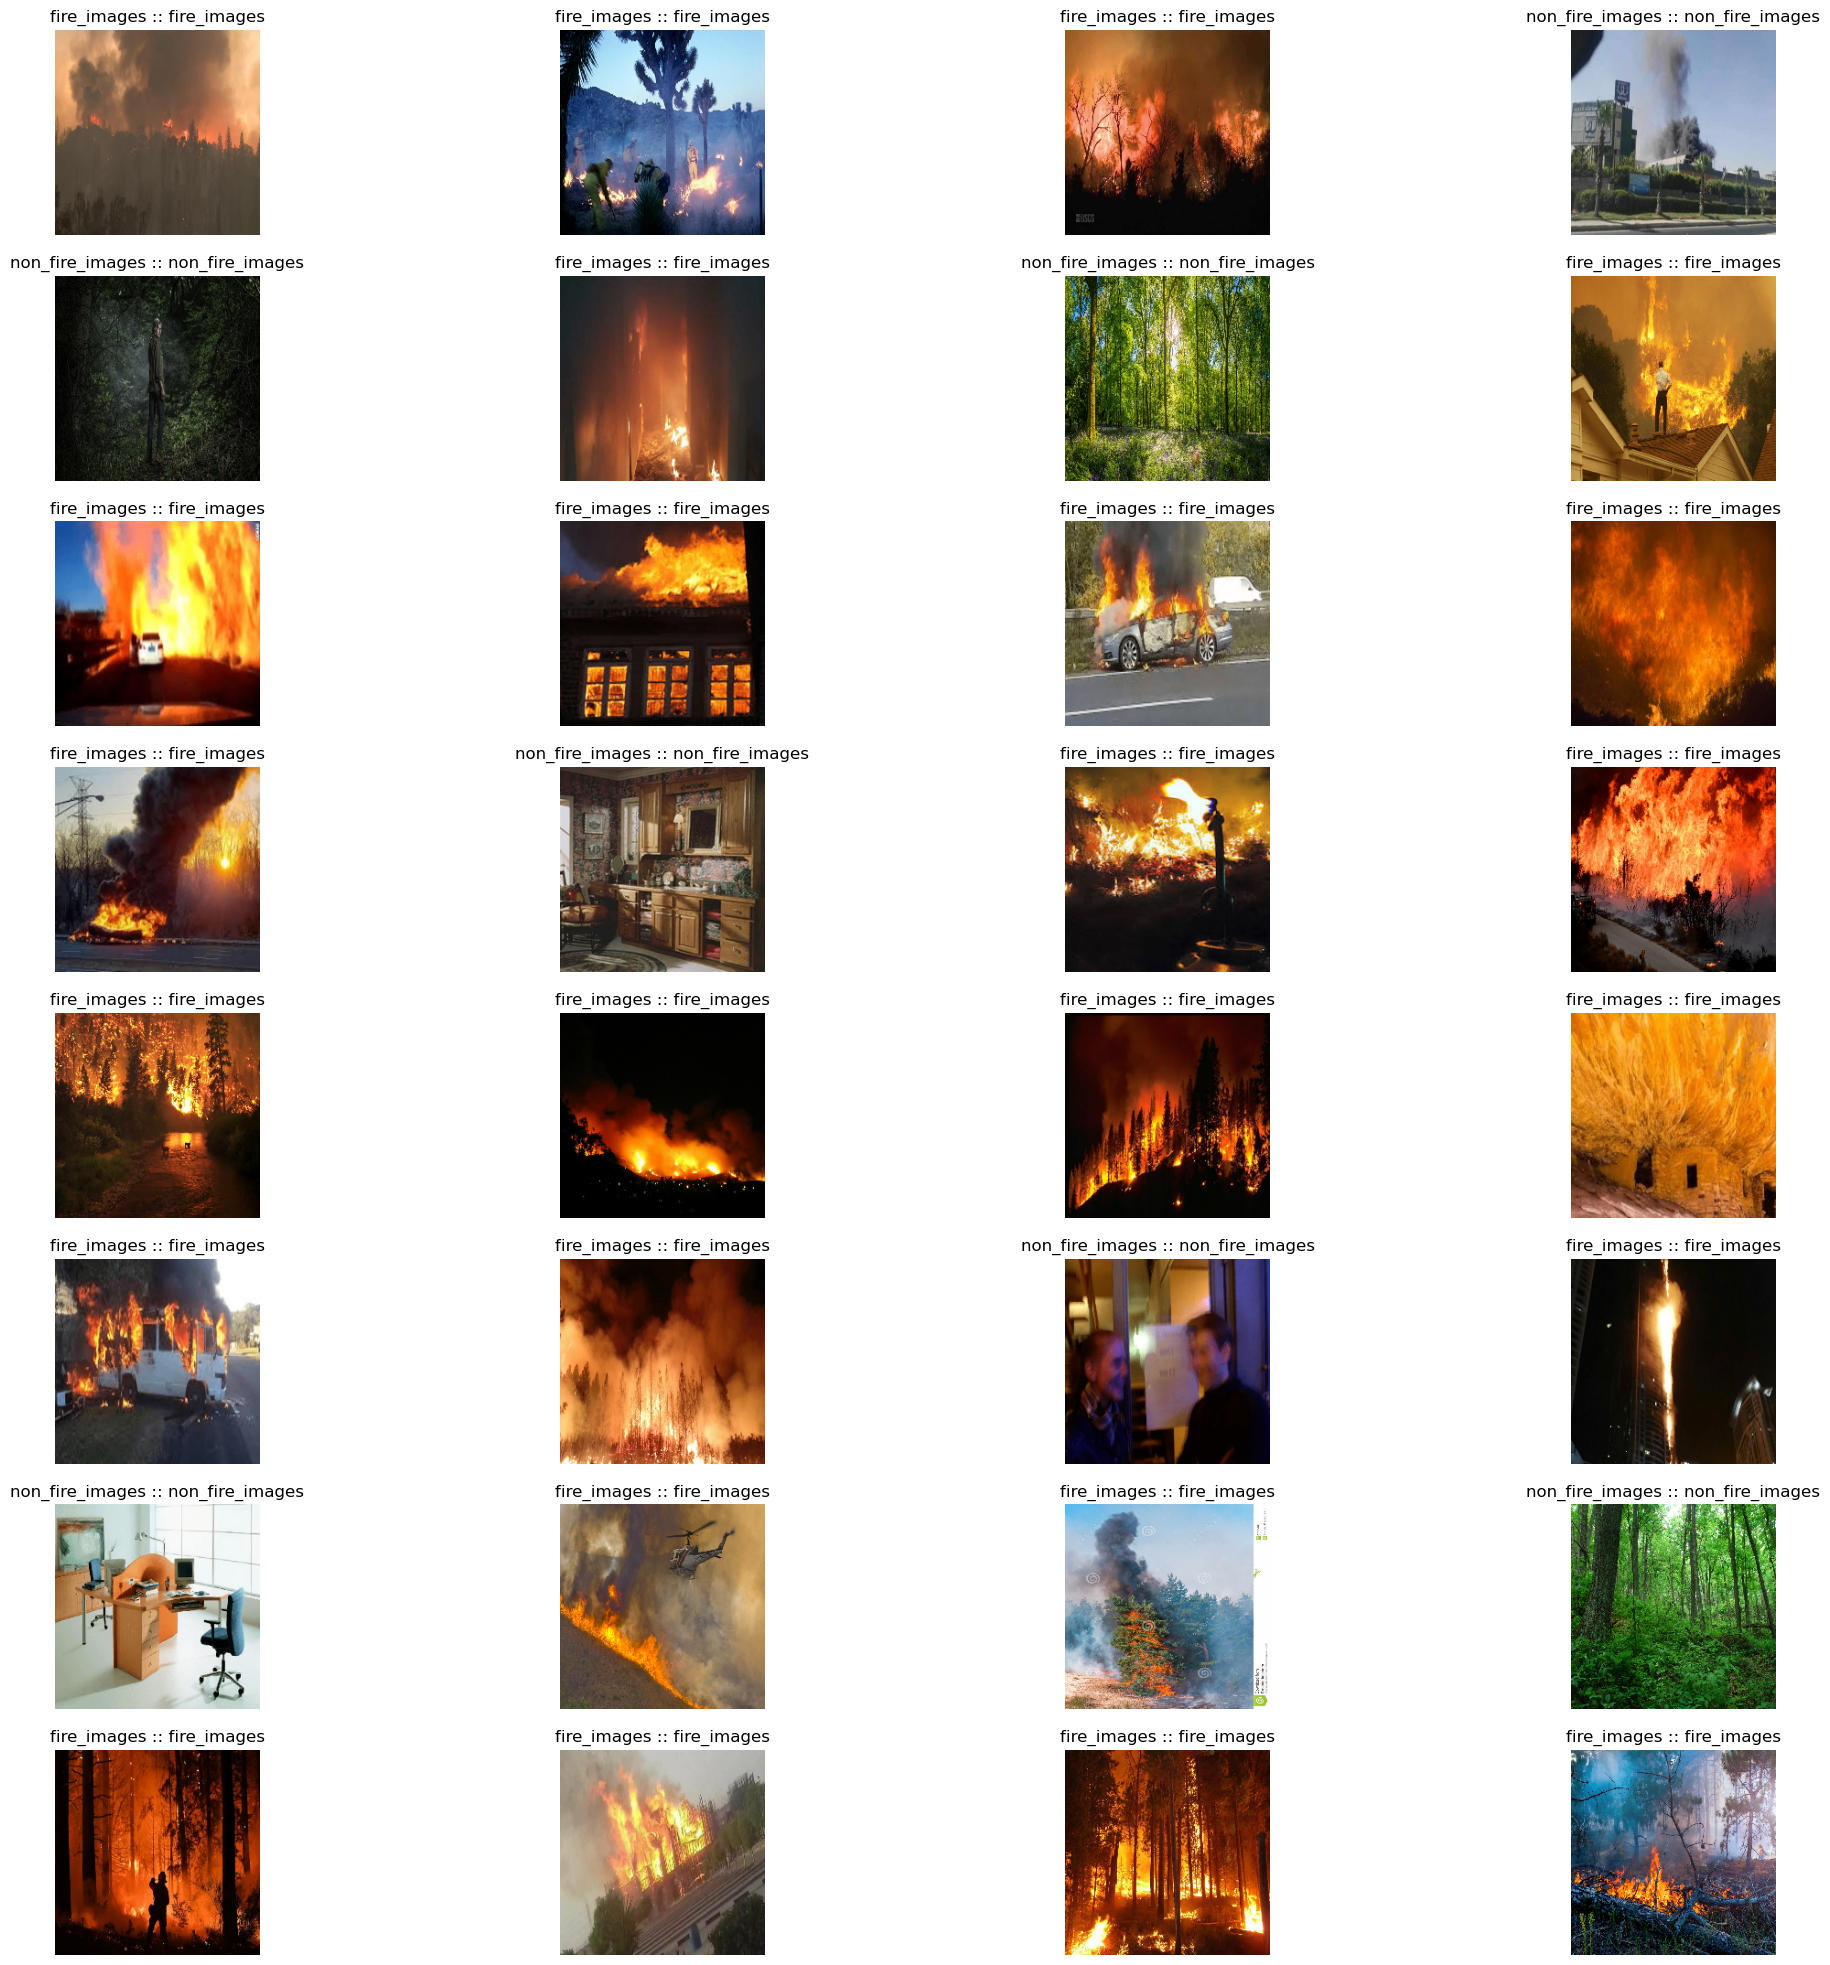

In [19]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i][0]]}')
    plt.axis("off")

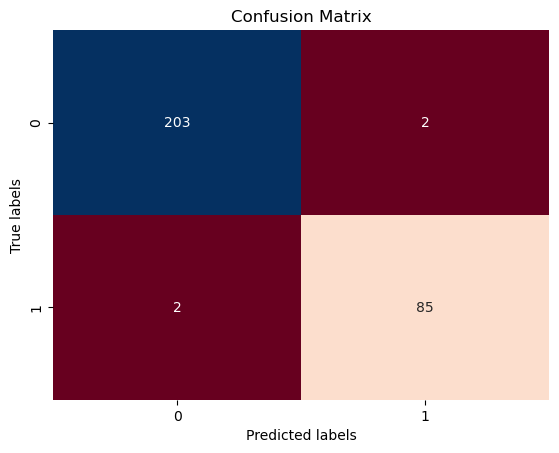

array([[203,   2],
       [  2,  85]], dtype=int64)

In [20]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()
CM

In [21]:
ClassificationReport = classification_report(y_val,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.99      0.99      0.99       205
           1       0.98      0.98      0.98        87

    accuracy                           0.99       292
   macro avg       0.98      0.98      0.98       292
weighted avg       0.99      0.99      0.99       292

